http://psh01com1hcom02:8885/tree?token=6b16ccaa3c414baf40fefa8b99b56a0132cb81aae64d0542

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn

run_output_dir = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/output/transformer_testing_output"

time_stamp_dfs = {"training_log" : None}
run_loss_dataframes = {}
for sub in os.listdir(run_output_dir):
    subpath = os.path.join(run_output_dir, sub)
    if sub.startswith("model_training") and os.path.isdir(subpath) and len(os.listdir(subpath)) > 0:
        time_stamp = "_".join([i for i in sub.split("_")[2:]])
        print(time_stamp)
        time_stamp_dfs[time_stamp] = {}
        
        training_log_file = os.path.join(subpath, "training_log.csv")
        if os.path.isfile(training_log_file):
            training_log_df = pd.read_csv(training_log_file, header=0, index_col=0)
            # print(training_log_df.head())
            
            
            time_stamp_dfs[time_stamp]["training_log"] = training_log_df
            
best_model_path = os.path.join(run_output_dir, "best_model_0.82_corr/training_log.csv")
best_model_df = pd.read_csv(best_model_path, header=0, index_col=0)
            


26_09_20_23_17
26_09_20_18_56
27_09_09_33_43
26_09_17_20_38
26_09_17_27_03
26_09_17_08_48


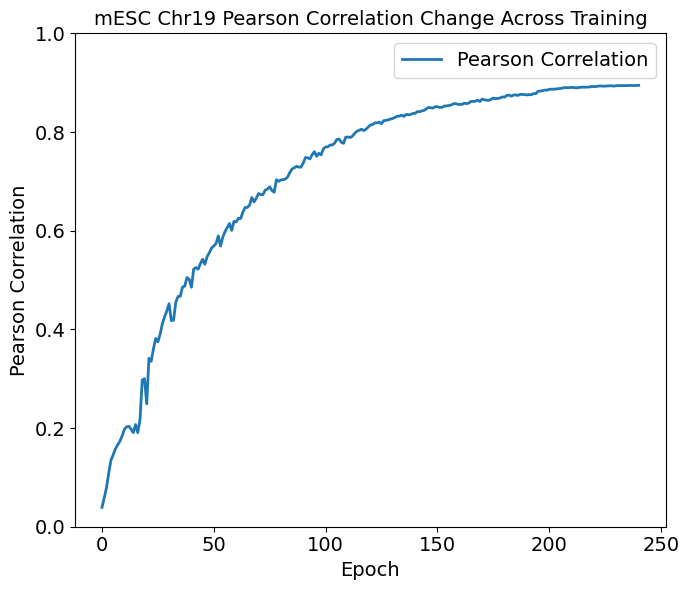

In [3]:
def plot_pearson_corr_across_epochs(df):
    fig = plt.figure(figsize=(7, 6))
    plt.plot(df.index, df["Pearson"], linewidth=2, label="Pearson Correlation")

    plt.title("mESC Chr19 Pearson Correlation Change Across Training", fontsize=14)
    plt.ylim((0,1))
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Pearson Correlation", fontsize=14)
    plt.legend(fontsize=14)
    plt.tight_layout()
    
    return fig

# df = time_stamp_dfs["25_09_13_48_09"]["training_log"]
df = best_model_df
fig = plot_pearson_corr_across_epochs(df)
fig.show()

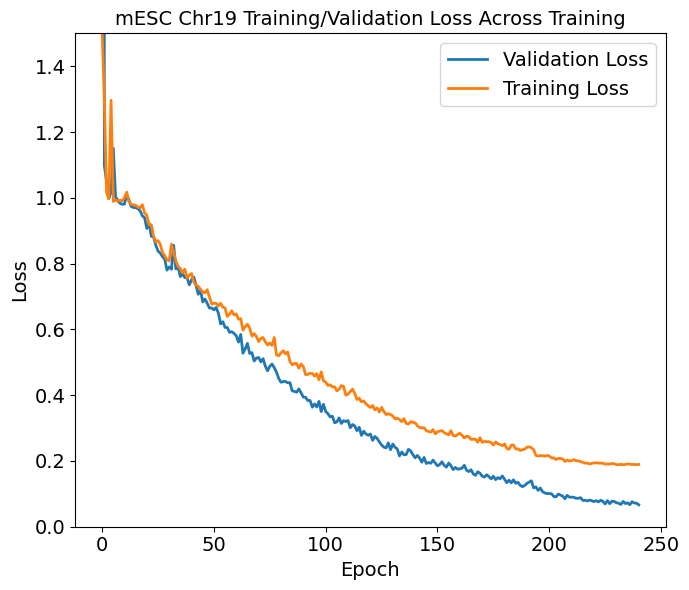

In [6]:
def plot_train_val_loss(df):
    fig = plt.figure(figsize=(7, 6))
    plt.plot(df.index, df["Train Loss"], linewidth=2, label="Validation Loss")
    plt.plot(df.index, df["Val Loss"], linewidth=2, label="Training Loss")

    plt.title("mESC Chr19 Training/Validation Loss Across Training", fontsize=14)
    plt.ylim((0,1.5))
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.legend(fontsize=14)
    plt.tight_layout()
    
    return fig
    
fig = plot_train_val_loss(df)
fig.show()

In [8]:
tf_imp_dir = os.path.join(run_output_dir, "best_model_0.82_corr/tf_gradient_attributions")

tf_imp_df_dict = {}
for file in os.listdir(tf_imp_dir):
    if file.endswith("_TF_importance.csv"):
        tf_name = file.split("_TF_importance.csv")[0]
        tf_imp_path = os.path.join(tf_imp_dir, file)
        
        tf_imp_df = pd.read_csv(tf_imp_path, header=0, index_col=0)

        if tf_name not in tf_imp_df_dict.keys():
            tf_imp_df_dict[tf_name] = tf_imp_df
            
print(tf_imp_df_dict.keys())
print(tf_imp_df_dict["Fau"])


dict_keys(['Fau'])
       importance
Amyb     0.096809
Ap-1     0.088824
Atoh1    0.030724
Hnf4a    0.085219
Hnf6     0.058023
...           ...
Gata2    0.021902
Gata4    0.041683
Gata6    0.034567
Gsx2     0.019142
Hnf1b    0.005106

[262 rows x 1 columns]


In [ ]:
from grn_inference.utils import minmax_norm_col

PROJECT_DIR = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER"

ground_truth_file = os.path.join(PROJECT_DIR, "ground_truth_files/mESC_beeline_ChIP-seq.csv")
chip_df = pd.read_csv(ground_truth_file)
chip_edges = set((g1.upper(), g2.upper()) for g1, g2 in zip(chip_df["Gene1"], chip_df["Gene2"]))

tf_name = "Btaf1"

# Normalize
df = tf_imp_df_dict[tf_name].copy()
df["importance"] = minmax_norm_col(df["importance"])

# Sort and keep top 25
df = df.sort_values(by="importance", ascending=False).iloc[:50]

# Build color list: gold if (Fau, TG) in chip_edges, else grey
colors = [
    "gold" if (tf_name.upper(), tg.upper()) in chip_edges else "grey"
    for tg in df.index
]

# Assert: at least one Fau → TG edge is in chip_edges
n_supported = sum((tf_name.upper(), tg.upper()) in chip_edges for tg in df.index)
assert n_supported > 0, f"No ChIP-supported edges found for {tf_name} in top 25"

# Plot
fig = plt.figure(figsize=(12,5))
plt.bar(x=df.index, height=df["importance"], color=colors)
plt.xticks(rotation=75)
plt.title(f"Top 25 targets of {tf_name}")
plt.show()

AssertionError: No ChIP-supported edges found for Fau in top 25

In [31]:
chip_df.head()

,Gene1,Gene2
0,ADNP,MIS18BP1
1,ADNP,EXD1
2,ADNP,CHP1
3,ADNP,OSCAR
4,ADNP,NDUFA3


In [39]:
print(chip_df.groupby("Gene1").count().sort_values(by="Gene2", ascending=False).index.str.capitalize().to_list()[:50])


['Nanog', 'Pou5f1', 'Utf1', 'Gabbr1', 'Dr1', 'Zfp281', 'Rnf2', 'Kmt2b', 'Tcf12', 'Nrf1', 'Tet1', 'Kdm4c', 'Prdm15', 'Sin3a', 'Btaf1', 'Taf2', 'Kdm2b', 'Mettl3', 'Kdm1a', 'Brd4', 'Kmt2d', 'Gtf3c1', 'Med12', 'Med1', 'Rad21', 'Suz12', 'Setd1a', 'Ddx21', 'Ncaph2', 'Zfp57', 'Ezh2', 'Tcf3', 'Kmt2c', 'Hexim1', 'Epop', 'Ep300', 'Ino80', 'Med26', 'Gtf2b', 'Fgfr1', 'Rad23b', 'Nelfa', 'Klf4', 'Zfp42', 'Esrrb', 'Tbp', 'Smarca4', 'Taf3', 'Zfp217', 'Supt5']
